# Late fusion pipeline

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
global_output_path = '../out/'
output_path = '../out/fusion/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Other functions

In [14]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(X_audio_df, y_audio_df, X_video_df, y_video_df, pipeline, title, file_name, report=False):
    scores = pipeline.predict_proba(X_audio_df = X_audio_df,
                                    X_video_df = X_video_df
                                   )   # Predict probabilities
    
    AUC_test = roc_auc_score(y_true=y_audio_df,
                             y_score=scores,
                             average='macro',
                             multi_class='ovo')  # Get AUC score
    print('AUC (test):', AUC_test)

    
    y_pred = pipeline.predict(X_audio_df = X_audio_df,
                          X_video_df = X_video_df
                         )
    
    conf_mat = confusion_matrix(y_audio_df, y_pred, normalize='true')
    df_cm = pd.DataFrame(conf_mat, list(emotion_id_to_emotion_num.keys()), list(emotion_id_to_emotion_num.keys()))

    
    fig=plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')
    plt.show()
    

### Load and fuse data

In [5]:
train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_late_fusion_train.csv'))
test_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_late_fusion_test.csv'))

train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_late_fusion_train.csv'))
test_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_late_fusion_test.csv'))

### Normalization

In [6]:
from sklearn import preprocessing
# WARNING: Video data is already normalized

# eGeMAPS dataset normalization
# load the model from disk
file_path = os.path.join(input_path,'audio','egemaps','min_max_scaler_egemaps_audio.sav')
min_max_scaler = pickle.load(open(file_path, 'rb'))

X = train_audio_df.drop(columns=['target'])                                 # Get features from train dataset
X_scaled = min_max_scaler.transform(X)                                  # Fit and transform features (train)
X_train_audio_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list()) # Create a dataframe from normalized features
X_train_audio_df.head()                                                     # Check dataframe
y_train_audio_df = train_audio_df.target                                    # Get target values


X = test_audio_df.drop(columns=['target'])                                  # Get features from test dataset
X_scaled = min_max_scaler.transform(X)                                      # Transform features (test)
X_test_audio_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())  # Create a dataframe from normalized features
y_test_audio_df = test_audio_df.target                                      # Get target values

## Late fusion configuration

### Audio and video classifiers 

In [7]:
from sklearn.ensemble import RandomForestClassifier

# For fusing validation
# We can not just load the best video and audio models, otherwise the pipeline AUC_avg would be biased.
# We use the obtained parameters from audio_modeling and video_modeling. We will use the best models once we evaluate the pipeline (after the cross validation)

audio_clf = RandomForestClassifier(bootstrap                = False,  # Create audio model with best parameters
                                   ccp_alpha                = 0.0,
                                   criterion                = 'gini',
                                   max_depth                = 20,
                                   max_features             = 'auto',                                
                                   max_leaf_nodes           = None,
                                   max_samples              = None,
                                   min_impurity_decrease    = 0.0,
                                   min_impurity_split       = None,
                                   min_samples_leaf         = 1,
                                   min_samples_split        = 5,
                                   min_weight_fraction_leaf = 0.0, 
                                   n_estimators             = 415,
                                   n_jobs                   = -1, 
                                   oob_score                = False,
                                   random_state             = seed,
                                   verbose                  = 0,
                                   warm_start               = False
                                  ) 

video_clf = RandomForestClassifier(bootstrap                = True,    # Create video model with best parameters
                                   ccp_alpha                =0.0,
                                   criterion                ='gini',
                                   max_depth                =10, 
                                   max_features             ='sqrt',
                                   max_leaf_nodes           =None, 
                                   max_samples              =None,
                                   min_impurity_decrease    =0.0, 
                                   min_impurity_split       =None,
                                   min_samples_leaf         =2, 
                                   min_samples_split        =2,
                                   min_weight_fraction_leaf =0.0,
                                   n_estimators             =490,
                                   n_jobs                   =-1, 
                                   oob_score                =False, 
                                   random_state             =seed,
                                   verbose                  =0,
                                   warm_start               =False
                                  ) 

# Test part
best_audio_clf_path = os.path.join(global_output_path, 'audio', 'models', 'mod_rf_egemaps_audio.sav')
best_video_clf_path = os.path.join(global_output_path, 'video', 'models', 'mod_rf_intensity_video.sav')

### Pipeline Class

In [8]:
class PipelineLateFusion:
    def __init__(self, audio_clf, video_clf, fusing_tech='sum', fusing_clf=None, audio_weight_ratio=0.15):
        # Input audio and video classifiers
        self.audio_model            = audio_clf
        self.video_model            = video_clf
        
        self.fusing_technique       = fusing_tech
        
        # Classifier fusion technique variables
        self.fusing_model           = fusing_clf
        
        # Weighted average fusion technique variables
        try:
            if audio_weight_ratio>=0 and audio_weight_ratio<=1:
                self.audio_weight_ratio = audio_weight_ratio
            else:
                raise
        except:
            print('Error: audio_weight_ratio must be between 0 and 1.')
            raise
            
            
    def predict(self, X_audio_df, X_video_df):
        audio_clf  = self.audio_model
        video_clf  = self.video_model
        fusing_clf = self.fusing_model
        
        audio_scores = audio_clf.predict_proba(X_audio_df)
        video_scores = video_clf.predict_proba(X_video_df)
        
        # Fusing techniques
        if   self.fusing_technique == 'sum':                              # Sum rule
            avg = ((audio_scores + video_scores) / 2)                     # Average scores
            out = avg.argmax(axis=1)                                      # Get classes
    
        elif self.fusing_technique == 'weight_crit':                      # Weight criterion
            audio_ratio = self.audio_weight_ratio                         # Get audio ratio
            video_ratio = 1 - self.audio_weight_ratio                     # Get video ratio
            avg = (audio_ratio*audio_scores + video_ratio*video_scores)   # Compute weighted scores
            out = avg.argmax(axis=1)                                      # Get classes
            
        elif self.fusing_technique == 'max':                              # Max rule
            max_pred = np.amax([audio_scores, video_scores], axis=0)      # Get max value rowise (between classifiers)
            max_norm = max_pred / max_pred.sum(axis=1)[:,None]            # Normalize predictions
            out = max_norm.argmax(axis=1)                                 # Get classes
        
        elif self.fusing_technique == 'prod':                             # Product rule
            prod = audio_scores*video_scores                              # Get product value rowise (between classifiers)
            prod_norm = prod / prod.sum(axis=1)[:,None]                   # Normalize predictions
            out = prod_norm.argmax(axis=1)                                # Get classes
        
        elif self.fusing_technique == 'rule':                             # Rule-based (I choose classifier according to validation confusion matrix)
            rul = np.column_stack((audio_scores[:,0],                     # adm emotion --> audio
                                   audio_scores[:,1],                     # amu emotion --> audio
                                   audio_scores[:,2],                     # att emotion --> audio
                                   video_scores[:,3],                     # col emotion --> video
                                   video_scores[:,4],                     # deg emotion --> video
                                   video_scores[:,5],                     # des emotion --> video
                                   audio_scores[:,6],                     # fie emotion --> audio
                                   video_scores[:,7],                     # hon emotion --> video
                                   video_scores[:,8],                     # inq emotion --> video
                                   audio_scores[:,9],                     # int emotion --> audio
                                   audio_scores[:,10],                    # irr emotion --> audio
                                   video_scores[:,11],                    # joi emotion --> video
                                   audio_scores[:,12],                    # mep emotion --> audio
                                   audio_scores[:,13],                    # peu emotion --> audio
                                   video_scores[:,14],                    # pla emotion --> video
                                   audio_scores[:,15],                    # sou emotion --> audio
                                   audio_scores[:,16],                    # sur emotion --> audio
                                   audio_scores[:,17]                     # tri emotion --> audio
                                   ))
            rul_norm = rul / rul.sum(axis=1)[:,None]                      # Normalize predictions
            out = rul_norm.argmax(axis=1)                                 # Get classes
            
        elif self.fusing_technique == 'clf':                              # Use trained classifier to predict the output probabilities
            try:
                if self.fusing_model is None:
                    raise
            except:
                print('Error: No fusing classifier was found.')

            out = fusing_clf.predict_proba(np.column_stack((audio_scores,video_scores)))
            out = out.argmax(axis=1)
        
        return out
        
        
    def predict_proba(self, X_audio_df, X_video_df):
        audio_clf  = self.audio_model
        video_clf  = self.video_model
        fusing_clf = self.fusing_model
        
        audio_scores = audio_clf.predict_proba(X_audio_df)
        video_scores = video_clf.predict_proba(X_video_df)
        
        # Fusing techniques
        if   self.fusing_technique == 'sum':                              # Average probabilities
            out = ((audio_scores + video_scores) / 2)                     # Average scores
            
        elif self.fusing_technique == 'weight_crit':                      # Weight criterion
            audio_ratio = self.audio_weight_ratio                         # Get audio ratio
            video_ratio = 1 - self.audio_weight_ratio                     # Get video ratio
            out = (audio_ratio*audio_scores + video_ratio*video_scores)   # Compute weighted scores
        
        elif self.fusing_technique == 'max':                              # Max rule
            max_pred = np.amax([audio_scores, video_scores], axis=0)      # Get max value rowise (between classifiers)
            out = max_pred / max_pred.sum(axis=1)[:,None]                 # Normalize predictions
        
        elif self.fusing_technique == 'prod':                             # Product rule
            prod = audio_scores*video_scores                              # Get product value rowise (between classifiers)
            out = prod / prod.sum(axis=1)[:,None]                         # Normalize predictions
        
        elif self.fusing_technique == 'rule':                             # Rule-based (I choose classifier according to validation confusion matrix)
            rul = np.column_stack((audio_scores[:,0],                     # adm emotion --> audio
                                   audio_scores[:,1],                     # amu emotion --> audio
                                   audio_scores[:,2],                     # att emotion --> audio
                                   video_scores[:,3],                     # col emotion --> video
                                   video_scores[:,4],                     # deg emotion --> video
                                   video_scores[:,5],                     # des emotion --> video
                                   audio_scores[:,6],                     # fie emotion --> audio
                                   audio_scores[:,7],                     # hon emotion --> audio
                                   video_scores[:,8],                     # inq emotion --> video
                                   audio_scores[:,9],                     # int emotion --> audio
                                   audio_scores[:,10],                    # irr emotion --> audio
                                   video_scores[:,11],                    # joi emotion --> video
                                   audio_scores[:,12],                    # mep emotion --> audio
                                   video_scores[:,13],                    # peu emotion --> video
                                   audio_scores[:,14],                    # pla emotion --> audio
                                   audio_scores[:,15],                    # sou emotion --> audio
                                   audio_scores[:,16],                    # sur emotion --> audio
                                   audio_scores[:,17]                     # tri emotion --> audio
                                   ))
            out = rul / rul.sum(axis=1)[:,None]                           # Normalize predictions
        
        elif self.fusing_technique == 'clf':                              # Use trained classifier to predict the output probabilities
            try:
                if self.fusing_model is None:
                    raise
            except:
                print('Error: No fusing classifier was found.')

            out  = fusing_clf.predict_proba(np.column_stack((audio_scores,video_scores)))
        
        return out
    
    def show(self):
        print('Audio model:', self.audio_model)
        print()
        print('Video model:', self.video_model)
        print()
        print('Fusing model:', self.fusing_model)

## Fusing techniques

### Sum rule

In [8]:
# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg = 0  # Initialize average AUC
for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    
    # Modify class weight, fit models and create pipeline
    audio_clf.class_weight = class_weight
    video_clf.class_weight = class_weight
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusing_clf  = None,
                                          fusing_tech = 'sum'
                                         )
    
    
    # Compute results (validation dataset)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio,
                                            X_video_df = X_val_video
                                           ) # Predict probabilities
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')     # Get AUC score
    AUC_avg += AUC_tmp                             # Add new AUC
    #print(AUC_tmp)
AUC_avg /= n_folds                                 # Get average AUC for alpha = a

# Add results to the results list
results.append(['sum',                             # fusing_tech
                AUC_avg
               ])



        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusing_tech','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_sum_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Load best model and create a pipeline with the best parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = None,
                                      fusing_tech = 'sum'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_sum.sav')
pickle.dump(best_model, open(file_path, 'wb'))

#print(best_model)

In [9]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,fusing_tech,AUC_avg
0,sum,0.897217


AUC (test): 0.914017336899817


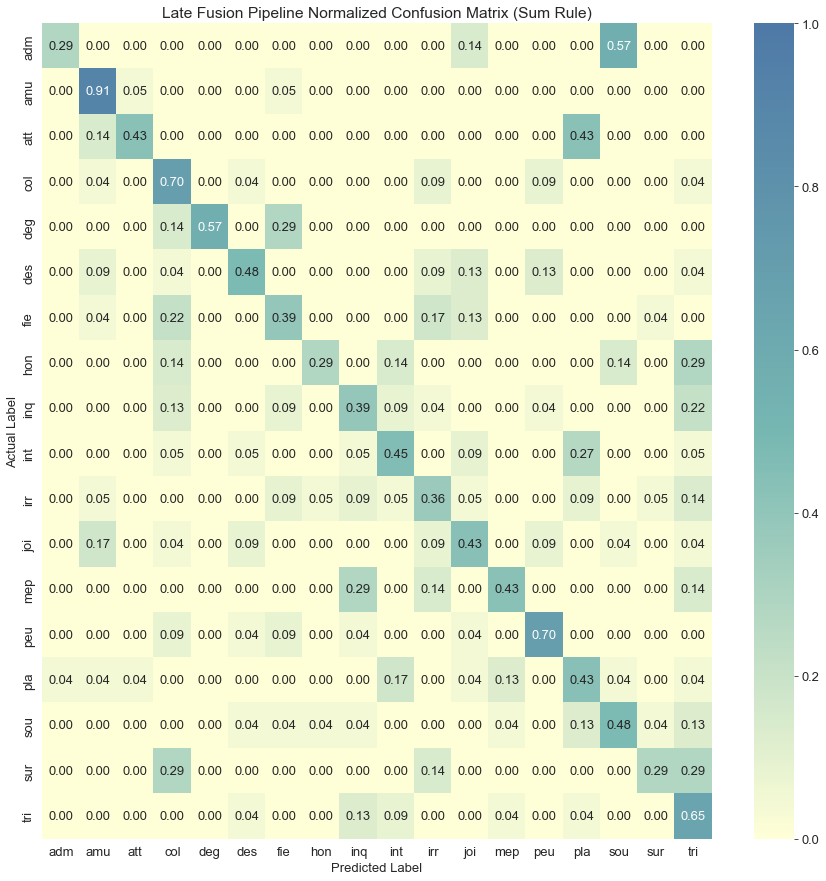

In [15]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_sum.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Sum Rule)',
                      file_name  = 'conf_mat_pipeline_late_fusion_sum.svg'
                     )

### Weight Criterion

In [11]:
# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate (fusing parameters)
audio_weight_ratio_values =  np.arange(0, 1.05, 0.05).tolist()
parameters = [(audio_weight_ratio,) for audio_weight_ratio in audio_weight_ratio_values]


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        
        # Modify class weight, fit models and create pipeline
        audio_clf.class_weight = class_weight
        video_clf.class_weight = class_weight
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        pipe_late_fusion = PipelineLateFusion(audio_clf          = audio_clf,
                                              video_clf          = video_clf,
                                              fusing_clf         = None,
                                              fusing_tech        = 'weight_crit',
                                              audio_weight_ratio = parameters[i][0]
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')                        # Get AUC score
        AUC_avg += AUC_tmp                                                # Add new AUC
        #print(AUC_tmp)
    AUC_avg /= n_folds                                                    # Get average AUC for alpha = a
    
    # Add results to the results list
    results.append([parameters[i][0],                                        # audio_weight_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters


        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['audio_weight_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_weight_crit_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Load best model and create a pipeline with the best parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = None,
                                      fusing_tech = 'weight_crit',
                                      audio_weight_ratio = params_best_model[0]
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_weight_crit.sav')
pickle.dump(best_model, open(file_path, 'wb'))

#print(best_model)

100%|██████████| 21/21 [08:39<00:00, 24.75s/it]


In [12]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,audio_weight_ratio,AUC_avg
11,0.55,0.897349
10,0.50,0.897217
12,0.60,0.896865
9,0.45,0.896692
13,0.65,0.895337


AUC (test): 0.9164090636384745


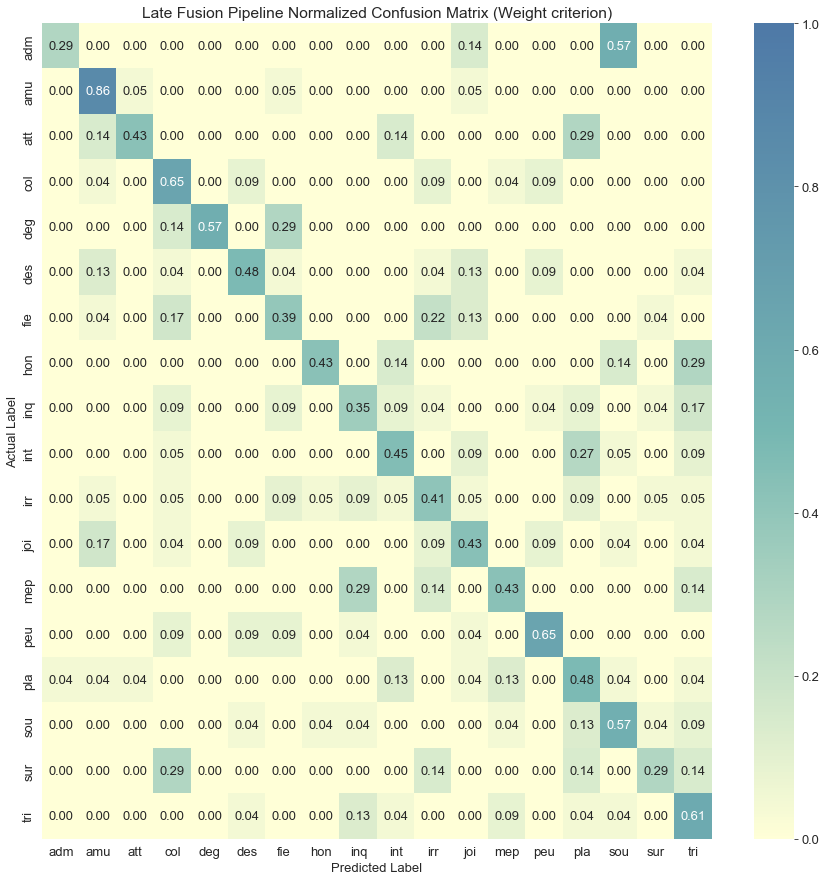

In [16]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_weight_crit.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Weight criterion)',
                      file_name  = 'conf_mat_pipeline_late_fusion_weight_crit.svg'
                     )

### Max rule

Selects the maximum of all posterior probabilities.

In [14]:
# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed) 


# Initialize some variables to store results
results = []
AUC_avg = 0  # Initialize average AUC
for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    
    # Modify class weight, fit models and create pipeline
    audio_clf.class_weight = class_weight
    video_clf.class_weight = class_weight
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusing_clf  = None,
                                          fusing_tech = 'max'
                                         )
    
    
    # Compute results (validation dataset)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio,
                                            X_video_df = X_val_video
                                           ) # Predict probabilities
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')     # Get AUC score
    AUC_avg += AUC_tmp                             # Add new AUC
    #print(AUC_tmp)
AUC_avg /= n_folds                                 # Get average AUC for alpha = a

# Add results to the results list
results.append(['max',                             # fusing_tech
                AUC_avg
               ])



        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusing_tech','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_max_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Load best model and create a pipeline with the best parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = None,
                                      fusing_tech = 'max'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_max.sav')
pickle.dump(best_model, open(file_path, 'wb'))

#print(best_model)

In [15]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,fusing_tech,AUC_avg
0,max,0.877254


AUC (test): 0.8979663243280618


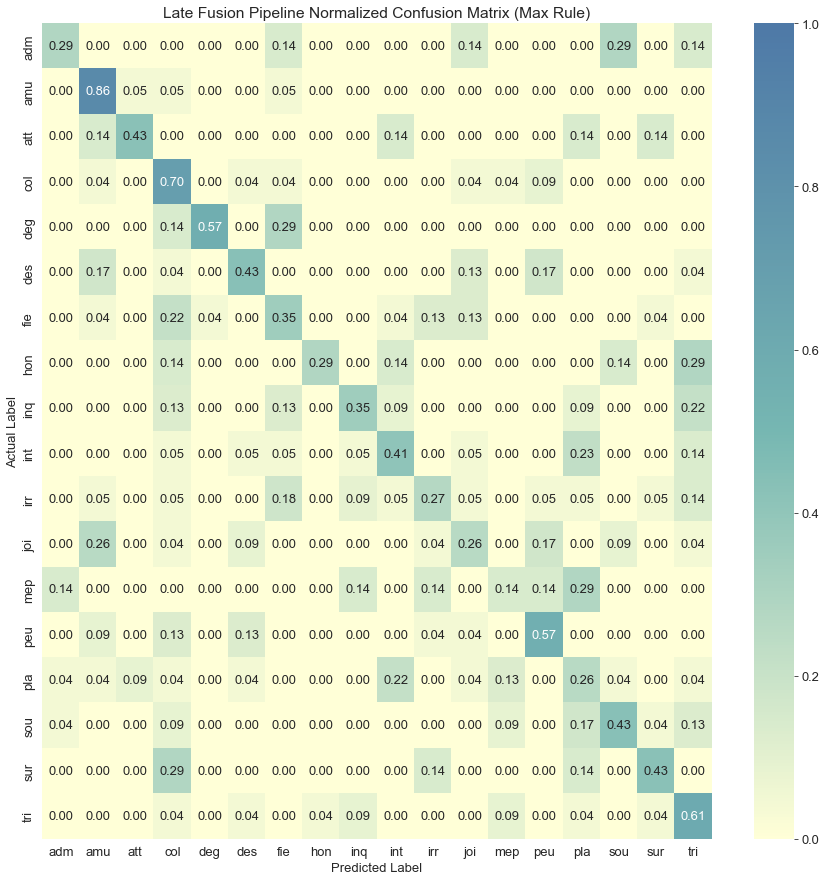

In [17]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_max.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Max Rule)',
                      file_name  = 'conf_mat_pipeline_late_fusion_max.svg'
                     )

### Product rule

In [17]:
# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg = 0  # Initialize average AUC
for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    
    # Modify class weight, fit models and create pipeline
    audio_clf.class_weight = class_weight
    video_clf.class_weight = class_weight   
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusing_clf  = None,
                                          fusing_tech = 'prod'
                                         )
    
    
    # Compute results (validation dataset)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio,
                                            X_video_df = X_val_video
                                           ) # Predict probabilities
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')     # Get AUC score
    AUC_avg += AUC_tmp                             # Add new AUC
    #print(AUC_tmp)
AUC_avg /= n_folds                                 # Get average AUC for alpha = a

# Add results to the results list
results.append(['prod',                            # fusing_tech
                AUC_avg
               ])



        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusing_tech','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_prod_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Load best model and create a pipeline with the best parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = None,
                                      fusing_tech = 'prod'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_prod.sav')
pickle.dump(best_model, open(file_path, 'wb'))

#print(best_model)

In [18]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,fusing_tech,AUC_avg
0,prod,0.907804


AUC (test): 0.9195508748162254


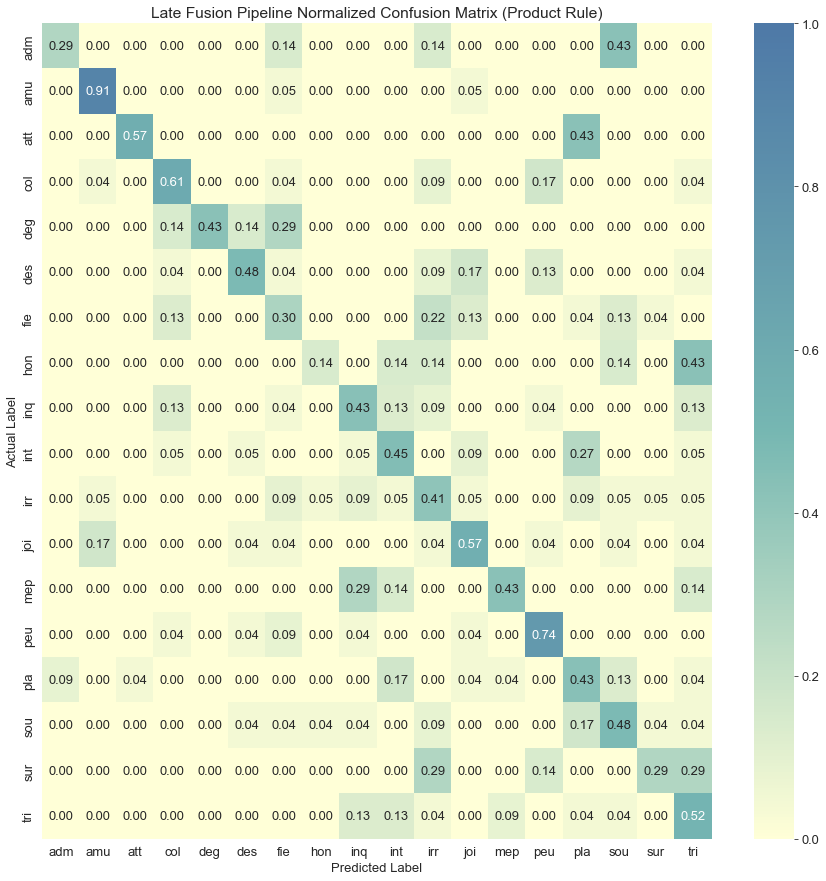

In [23]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_prod.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Product Rule)',
                      file_name  = 'conf_mat_pipeline_late_fusion_prod.svg',
                      report     = True
                     )

### Rule-based

In [20]:
# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Initialize some variables to store results
results = []
AUC_avg = 0  # Initialize average AUC
for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Compute class weight
    class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    class_weight = {n:class_weight[n] for n in range(0,18)}
    
    
    # Modify class weight, fit models and create pipeline
    audio_clf.class_weight = class_weight
    video_clf.class_weight = class_weight   
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusing_clf  = None,
                                          fusing_tech = 'rule'
                                         )
    
    
    # Compute results (validation dataset)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio,
                                            X_video_df = X_val_video
                                           ) # Predict probabilities
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='macro',
                            multi_class='ovo')     # Get AUC score
    AUC_avg += AUC_tmp                             # Add new AUC
    #print(AUC_tmp)
AUC_avg /= n_folds                                 # Get average AUC for alpha = a

# Add results to the results list
results.append(['rule',                            # fusing_tech
                AUC_avg
               ])



        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusing_tech','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_rule_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)


# Load best model and create a pipeline with the best parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = None,
                                      fusing_tech = 'rule'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_rule.sav')
pickle.dump(best_model, open(file_path, 'wb'))

#print(best_model)

In [21]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,fusing_tech,AUC_avg
0,rule,0.867073


AUC (test): 0.898284217476562


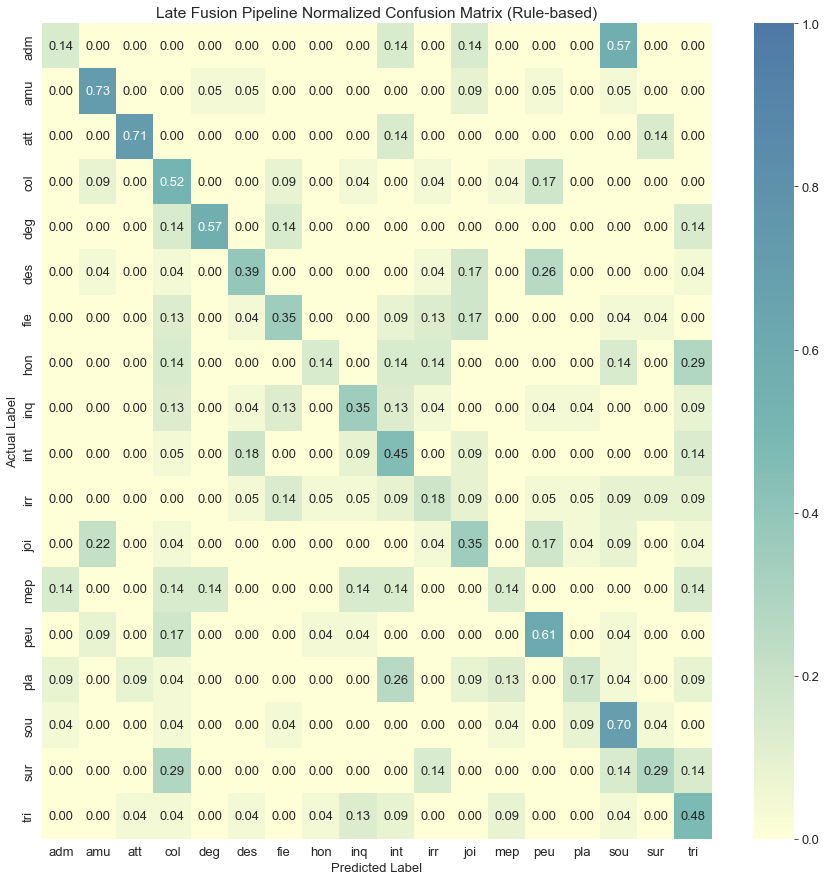

In [19]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_rule.sav')
pipeline = pickle.load(open(file_path, 'rb'))


plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Rule-based)',
                      file_name  = 'conf_mat_pipeline_late_fusion_rule.svg'
                     )

### Model-based

#### Elastic Net

In [23]:
from sklearn.linear_model import SGDClassifier

# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate (fusing classifier)
alpha_values    = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.03, 0.05, 0.07, 0.1, 1]
loss_values     = ['log', 'modified_huber']
l1_ratio_values = np.arange(0.05, 1.05, 0.05).tolist()
parameters      = [(alpha,loss,l1_ratio)  
                   for alpha in alpha_values
                   for loss in loss_values
                   for l1_ratio in l1_ratio_values
                  ]


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    fusing_clf = SGDClassifier(penalty      = 'elasticnet',
                               alpha        = parameters[i][0],
                               loss         = parameters[i][1],
                               l1_ratio     = parameters[i][2],
                               random_state = seed,
                               n_jobs       = -1
                              )
    for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        
        # Modify class weight, fit models and create pipeline
        audio_clf.class_weight = class_weight
        video_clf.class_weight = class_weight
        fusing_clf.class_weight = class_weight
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusing_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusing_clf  = fusing_clf,
                                              fusing_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')                        # Get AUC score
        AUC_avg += AUC_tmp                                                # Add new AUC
        #print(AUC_tmp)
    AUC_avg /= n_folds                                                    # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # Loss
                    parameters[i][2],               # L1_ratio
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','Loss','L1_ratio','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_elastic_net_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)




# Load best audio and video models and create a pipeline with the best fusing classifier parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
audio_scores = audio_clf_tmp.predict_proba(X_audio_df)
video_scores = video_clf_tmp.predict_proba(X_video_df)

# Train fusing model with the parameters of the best model (full training set) 
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_audio_df), y=y_audio_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_fusing_model = SGDClassifier(penalty      = 'elasticnet',
                                  alpha        = params_best_model[0],
                                  loss         = params_best_model[1],
                                  l1_ratio     = params_best_model[2],
                                  random_state = seed,
                                  n_jobs       = -1,
                                  class_weight = class_weight
                                 )
best_fusing_model.fit(np.column_stack((audio_scores,video_scores)),y_audio_df)
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = best_fusing_model,
                                      fusing_tech = 'clf'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_elastic_net.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_fusing_model)

100%|██████████| 400/400 [2:55:24<00:00, 26.31s/it]  


SGDClassifier(alpha=0.01, average=False,
              class_weight={0: 2.2801932367149758, 1: 0.7712418300653595,
                            2: 2.2801932367149758, 3: 0.7827529021558872,
                            4: 2.2801932367149758, 5: 0.7827529021558872,
                            6: 0.7827529021558872, 7: 2.2801932367149758,
                            8: 0.7827529021558872, 9: 0.7827529021558872,
                            10: 0.7712418300653595, 11: 0.7827529021558872,
                            12: 2.2801932367149758, 13: 0.7827529021558872,
                            14: 0.7827529021558872, 15: 0.7827529021558872,
                            16: 2.2801932367149758, 17: 0.7827529021558872},
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.05, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='elasticnet', power_t=0.5,
              random_state=24, shuffle=True,

In [24]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,Penalty,Alpha,Loss,L1_ratio,AUC_avg
160,elasticnet,0.010,log,0.05,0.897498
120,elasticnet,0.001,log,0.05,0.896614
161,elasticnet,0.010,log,0.10,0.896571
121,elasticnet,0.001,log,0.10,0.896277
200,elasticnet,0.030,log,0.05,0.895696


AUC (test): 0.9202075613270612


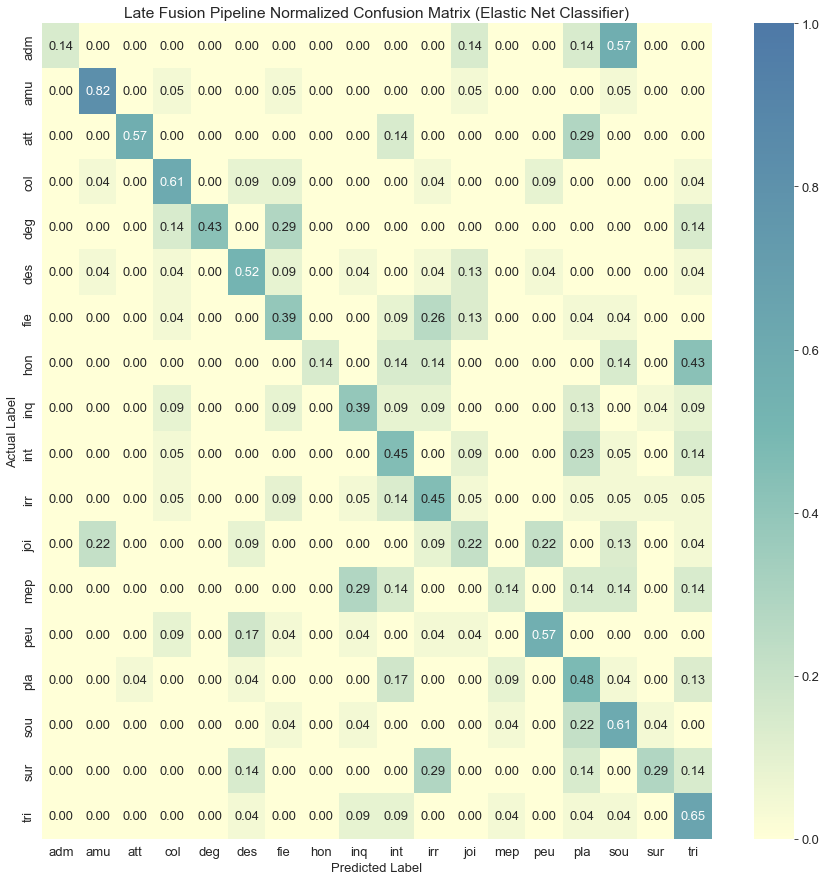

In [20]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_elastic_net.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier)',
                      file_name  = 'conf_mat_pipeline_late_fusion_clf_elastic_net.svg'
                     )

#### kNN Classifier

In [26]:
from sklearn.neighbors import KNeighborsClassifier


# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate (fusing classifier)
n_neigh_values   = np.arange(50, 205, 5).tolist()
leaf_size_values = np.arange(30, 105, 5).tolist()
weights_values   = ['uniform', 'distance']
parameters = [(n_neigh,leaf_size,weights)  
              for n_neigh in n_neigh_values
              for leaf_size in leaf_size_values
              for weights in weights_values
             ]


# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    fusing_clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                      leaf_size    = parameters[i][1],
                                      weights      = parameters[i][2],
                                      n_jobs       = -1
                                     )
    for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        
        # Modify class weight, fit models and create pipeline
        audio_clf.class_weight = class_weight
        video_clf.class_weight = class_weight
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusing_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusing_clf  = fusing_clf,
                                              fusing_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')                        # Get AUC score
        AUC_avg += AUC_tmp                                                # Add new AUC
        #print(AUC_tmp)
    AUC_avg /= n_folds                                                    # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # n_neighbors
                    parameters[i][1],                 # leaf_size
                    parameters[i][2],                 # weights
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_knn_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)




# Load best audio and video models and create a pipeline with the best fusing classifier parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
audio_scores = audio_clf_tmp.predict_proba(X_audio_df)
video_scores = video_clf_tmp.predict_proba(X_video_df)

# Train fusing model with the parameters of the best model (full training set) 
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_audio_df), y=y_audio_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_fusing_model = KNeighborsClassifier(n_neighbors  = params_best_model[0],
                                  leaf_size    = params_best_model[1],
                                  weights      = params_best_model[2],
                                  n_jobs       = -1
                                 )
best_fusing_model.fit(np.column_stack((audio_scores,video_scores)),y_audio_df)
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = best_fusing_model,
                                      fusing_tech = 'clf'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_knn.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_fusing_model)

100%|██████████| 930/930 [4:49:45<00:00, 18.69s/it]  


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=200, p=2,
                     weights='distance')


In [27]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,k_neighbors,leaf_size,weights,AUC_avg
929,200,100,distance,0.80785
911,200,55,distance,0.80785
913,200,60,distance,0.80785
909,200,50,distance,0.80785
915,200,65,distance,0.80785


AUC (test): 0.8290955021366554


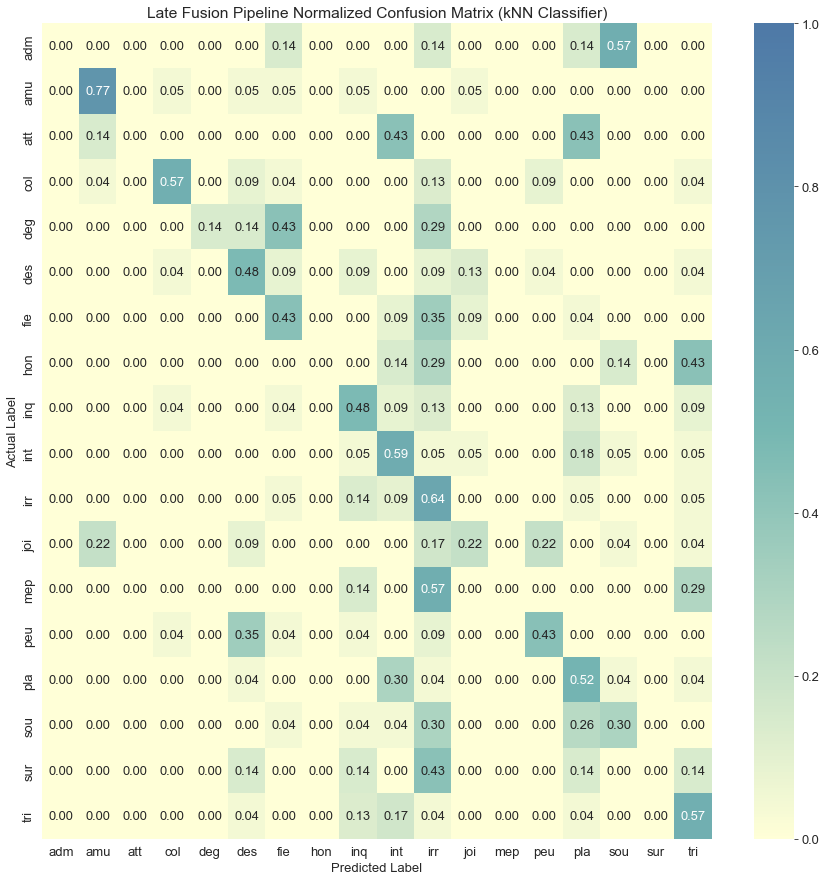

In [21]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_knn.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (kNN Classifier)',
                      file_name  = 'conf_mat_pipeline_late_fusion_clf_knn.svg'
                     )

#### Decision Tree

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample



# Create new variables to split the train dataset into k folds
X_audio_df = X_train_audio_df
y_audio_df = y_train_audio_df
X_video_df = train_video_df.drop(columns='target')
y_video_df = train_video_df.target
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)


# Define parameters to evaluate (fusing classifier)
criterion_values         = ['gini']
splitter_values          = ['best']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, 18*2, num = 18)]
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]
# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=900, replace=False, random_state=seed)

# Initialize some variables to store results
results = []
AUC_avg_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC_avg = 0  # Initialize average AUC
    fusing_clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                        splitter          = parameters[i][1],
                                        max_depth         = parameters[i][2],
                                        min_samples_split = parameters[i][3],
                                        min_samples_leaf  = parameters[i][4],
                                        max_features      = parameters[i][5],
                                        random_state      = seed
                                       )
    for train_idx, val_idx in skf.split(X_audio_df, y_audio_df):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Compute class weight
        class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
        class_weight = {n:class_weight[n] for n in range(0,18)}
        
        
        # Modify class weight, fit models and create pipeline
        audio_clf.class_weight = class_weight
        video_clf.class_weight = class_weight
        fusing_clf.class_weight = class_weight
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusing_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusing_clf  = fusing_clf,
                                              fusing_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='macro',
                                multi_class='ovo')                        # Get AUC score
        AUC_avg += AUC_tmp                                                # Add new AUC
        #print(AUC_tmp)
    AUC_avg /= n_folds                                                    # Get average AUC for alpha = a
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg > AUC_avg_best_model:
        AUC_avg_best_model = AUC_avg                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_tree_'+str(n_folds)+'_fold_cv.csv'), index=None, header=True)




# Load best audio and video models and create a pipeline with the best fusing classifier parameters (best validation AUC_avg)
audio_clf_tmp = pickle.load(open(best_audio_clf_path, 'rb'))       # Load video audio from disk
video_clf_tmp = pickle.load(open(best_video_clf_path, 'rb'))       # Load video model from disk
audio_scores = audio_clf_tmp.predict_proba(X_audio_df)
video_scores = video_clf_tmp.predict_proba(X_video_df)

# Train fusing model with the parameters of the best model (full training set) 
class_weight = compute_class_weight(class_weight='balanced', classes=np.unique(y_audio_df), y=y_audio_df)
class_weight = {n:class_weight[n] for n in range(0,18)}
best_fusing_model = DecisionTreeClassifier(criterion         = params_best_model[0],
                                           splitter          = params_best_model[1],
                                           max_depth         = params_best_model[2],
                                           min_samples_split = params_best_model[3],
                                           min_samples_leaf  = params_best_model[4],
                                           max_features      = params_best_model[5],
                                           random_state      = seed,
                                           class_weight      = class_weight
                                        )
best_fusing_model.fit(np.column_stack((audio_scores,video_scores)),y_audio_df)
pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf_tmp,
                                      video_clf   = video_clf_tmp,
                                      fusing_clf  = best_fusing_model,
                                      fusing_tech = 'clf'
                                      )
best_model = pipe_late_fusion

# Save the best model to disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_tree.sav')
pickle.dump(best_model, open(file_path, 'wb'))

print(best_fusing_model)

100%|██████████| 900/900 [4:43:29<00:00, 18.90s/it]  


DecisionTreeClassifier(ccp_alpha=0.0,
                       class_weight={0: 2.2801932367149758,
                                     1: 0.7712418300653595,
                                     2: 2.2801932367149758,
                                     3: 0.7827529021558872,
                                     4: 2.2801932367149758,
                                     5: 0.7827529021558872,
                                     6: 0.7827529021558872,
                                     7: 2.2801932367149758,
                                     8: 0.7827529021558872,
                                     9: 0.7827529021558872,
                                     10: 0.7712418300653595,
                                     11: 0.7827529021558872,
                                     12: 2.2801932367149758,
                                     13: 0.7827529021558872,
                                     14: 0.7827529021558872,
                                     15: 0.78275290215588

In [30]:
results_df.sort_values(by='AUC_avg', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg
873,gini,best,45,0.2,0.2,7,0.648178
874,gini,best,15,0.1,0.2,7,0.648178
485,gini,best,50,0.1,0.2,7,0.648178
164,gini,best,30,0.4,0.2,7,0.648178
284,gini,best,20,0.4,0.2,7,0.648178


AUC (test): 0.6459601814760806


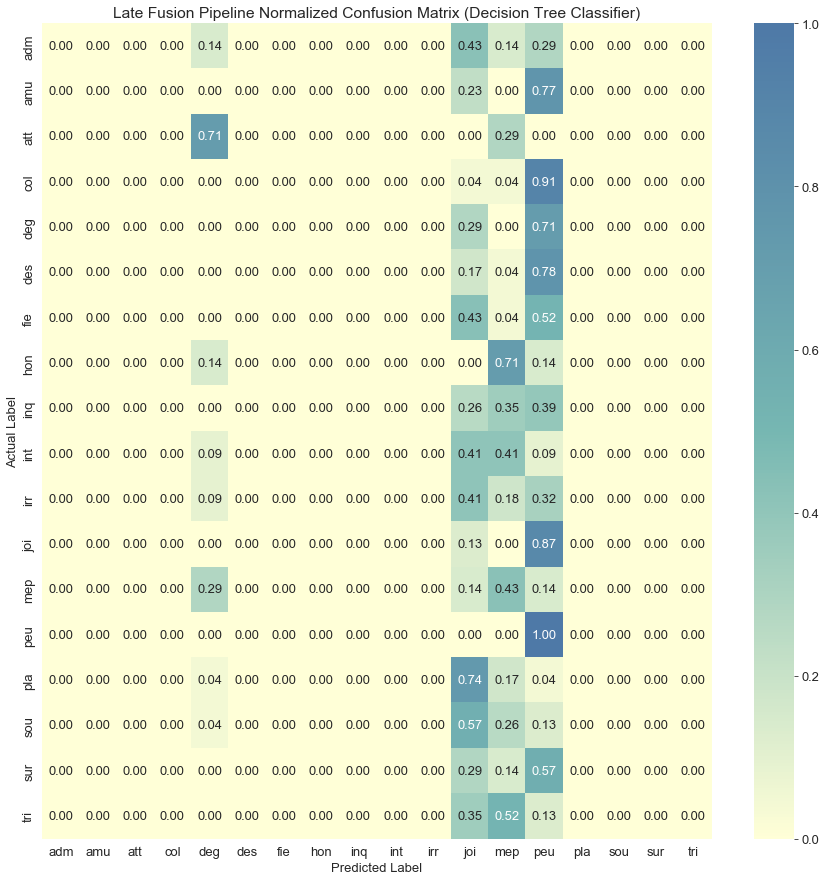

In [22]:
from sklearn.metrics import confusion_matrix

# Create new variables to split the train dataset into k folds
X_audio_df = X_test_audio_df
y_audio_df = y_test_audio_df
X_video_df = test_video_df.drop(columns='target')
y_video_df = test_video_df.target


# load the pipeline from disk
file_path = os.path.join(output_path,'models','pipeline_late_fusion_clf_tree.sav')
pipeline = pickle.load(open(file_path, 'rb'))

plot_save_conf_matrix(X_audio_df = X_audio_df,
                      y_audio_df = y_audio_df,
                      X_video_df = X_video_df,
                      y_video_df = y_video_df,
                      pipeline   = pipeline,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier)',
                      file_name  = 'conf_mat_pipeline_late_fusion_clf_tree.svg'
                     )